In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from matplotlib.colors import LogNorm
import math

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5') 
latent_dim = 1
decoder = tf.keras.models.load_model('../models/vaeffnn_decoder.h5', custom_objects={'latent_dim': latent_dim})
encoder = tf.keras.models.load_model('../models/vaeffnn_encoder.h5')
ffnn_do = tf.keras.models.load_model('../models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})
#ffnn_do 2 and without 2


In [3]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)


-0.01084098704 0.02815552265 0.00039265133851975654


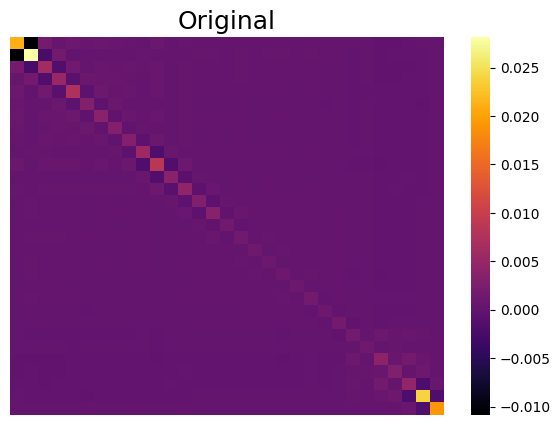

In [4]:
plt.figure(figsize=(7, 5), dpi=100)

plt.title('Original', fontsize=18)
sns.heatmap(syscov, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)
# sns.set(font_scale=1)

plt.savefig('originalcov.png')

In [5]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

## Generation of matrix to explore the latent space

In [6]:
def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = 10**orderMag(matrix[row, col])
    return magMatrix

def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) > np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix           

def matrixGenerator(omatrix, nmatrix, noise_factor=0.01):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        print("Generating matrix {}".format(it+1), end='\r')
        mag = matrixMag(omatrix)
        m = omatrix + np.multiply(noise_factor*np.random.randn(nsize,nsize), mag)       
        matrixset[it, :, :] = m
        
    return matrixset
            

In [7]:
numMatrix = 2000
# covset, D = matrixGenerator3(syscov, numMatrix)
covset = matrixGenerator(syscov, numMatrix, noise_factor=0.1)

In [8]:
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))

## Exploring latent space distribution

In [9]:
x_test_encoded = encoder.predict(covset_test)
z_mean = x_test_encoded[0]
z_std = x_test_encoded[1]
z_latent = x_test_encoded[2]

In [10]:
xmin = np.min(z_mean)#-0.1*10**orderMag(meanmean)
xmax = np.max(z_mean)#+0.1*10**orderMag(meanmean)
ymin = np.min(z_std)#-0.1*10**orderMag(meanmean)
ymax = np.max(z_std)#+0.1*10**orderMag(meanmean)
meanmean = np.mean(z_mean)
meanstd = np.mean(z_std)

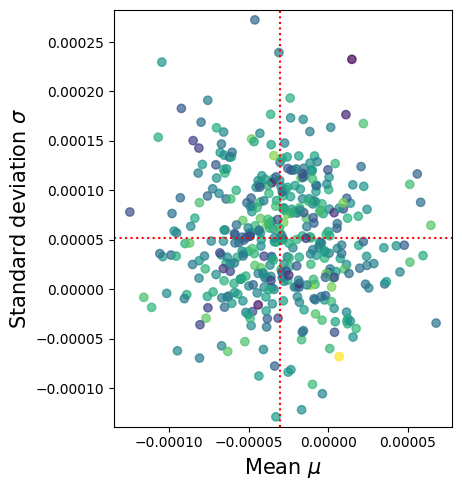

In [11]:
# plt.figure(figsize=(8,8), dpi=100)
plt.figure(figsize=(5, 5), dpi=100)

# fig, ax = plt.subplots()

# ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.scatter(z_mean, z_std, marker='o', c=z_latent, alpha=0.7)
plt.xlabel('Mean $\mu$', fontsize=15)
plt.ylabel('Standard deviation $\sigma$', fontsize=15)
meanmean = np.mean(z_mean)
meanstd = np.mean(z_std)
# plt.text('Average mean: {:.5f} | Average std: {:.5f}'.format(meanmean, meanstd), fontsize=18)

# ax.xaxis.set_ticks(np.arange(xmin, xmax, 1e-10))
# plt.colorbar()

plt.xlim(xmin-1e-5, xmax+1e-5)
plt.ylim(ymin-1e-5, ymax+1e-5)
plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
plt.hlines(meanstd, xmin-1e-5, xmax+1e-5, colors='r', linestyles='dotted')
plt.vlines(meanmean, ymin-1e-5, ymax+1e-5, colors='r', linestyles='dotted')
plt.tight_layout()
plt.savefig('mean_sigma_latent.png', transparent=True)

<Figure size 800x500 with 0 Axes>

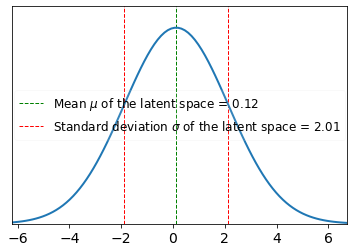

In [12]:
plt.figure(figsize=(8, 5), dpi=100)
f, ax = plt.subplots()

xmin = np.min(z_latent)
xmax= np.max(z_latent)
x = np.linspace(xmin, xmax, 100)
y0 = sp.stats.norm.pdf(x, np.mean(z_latent), np.std(z_latent))
# sns.displot(z_latent, kind='kde')
ax.set_yticks([])
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 0.22)
# plt.xlabel('Mean $\mu$ of the latent )

s1 = np.mean(z_latent) - np.std(z_latent)
s2 = np.mean(z_latent) + np.std(z_latent)

# xlabels = [r"$\sigma$", r"$Mean \; \mu$", r"$\sigma$"]
# xticks = [s1, np.mean(z_latent), s2]
# ax.set_xticks(xticks) 
# ax.set_xticklabels(xlabels) 
# ax.text(-1.95, 0.075, 'Mean $\mu$ = {:.2f}'.format(np.mean(z_latent)), fontsize=13)

# plt.xticks(xticks)
# plt.xticklabels(xtickslabels)

plt.xticks(fontsize=14)
# plt.vlines(0, 0.22, np.mean(z_latent))
ax.axvline(x=np.mean(z_latent), color='g', linewidth=1.0, linestyle='--',\
            label='Mean $\mu$ of the latent space = ${:.2f}$'.format(np.mean(z_latent))) 
plt.axvline(x=s1, color='r', linewidth=1.0, linestyle='--',\
            label='Standard deviation $\sigma$ of the latent space = ${:.2f}$'.format(np.std(z_latent))) 
plt.axvline(x=s2, color='r', linewidth=1.0, linestyle='--') 
# plt.vlines(0, 0.22, s2)
plt.legend(loc='center', framealpha=0.1, fontsize=12)

plt.plot(x, y0, linewidth=2)
plt.savefig('latent_dist.png')

## Using new points, uniformly distributed under the log10-scale

In [13]:
zseedlog = np.linspace(np.log10(0.01), np.log10(1.3), 31)
zpoints = 10**zseedlog
# zpoints = z_redshift
# zpoints = ranz+0.01*np.random.randn(31)
# orderMag(0.1)
# zpoints = zpoints+ 0.01*np.random.rand(31)
zpoints

array([0.01      , 0.01176156, 0.01383342, 0.01627025, 0.01913635,
       0.02250733, 0.02647212, 0.03113533, 0.03661999, 0.04307081,
       0.05065797, 0.05958166, 0.0700773 , 0.0824218 , 0.09694087,
       0.11401754, 0.13410237, 0.15772525, 0.18550944, 0.21818796,
       0.25662299, 0.30182857, 0.35499736, 0.41753213, 0.49108275,
       0.57758973, 0.67933539, 0.79900412, 0.93975316, 1.10529594,
       1.3       ])

## Using syscov in encoder to reference 

In [14]:
ztest2 = encoder.predict(syscov.reshape((-1,31*31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
mean_ref = np.mean(dist)
std_ref = np.std(dist)
delta_mean = z_sample_syscov - mean_ref


In [15]:
pred_random = ffnn.predict(np.log10(zpoints))
# pred_random = ffnn.predict(zpoints)
dlfake = scalerdist.inverse_transform(pred_random.reshape(-1,1))
index = np.argsort(zpoints)
dlfake = dlfake.reshape(31,)[index]
zpoints = zpoints[index]
fake_data = np.stack((zpoints, dlfake), axis=1)

# np.savetxt("fake_binned_JLA_inter.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

## Finding mean and std to the new data to make a new cov matrix with the decoder

In [16]:
mean_pred_interpoint = np.mean(dlfake)
std_pred_interpoint = np.std(dlfake)

In [17]:
z_sample = np.array([mean_pred_interpoint+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

mudiff = np.subtract(dist, dlfake.reshape(31,))
errdiff = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr)))

## Cosmo models

In [18]:
def RHSquared_a_owacdm(a, w0, wa, Om):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r
    
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+43.15

zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

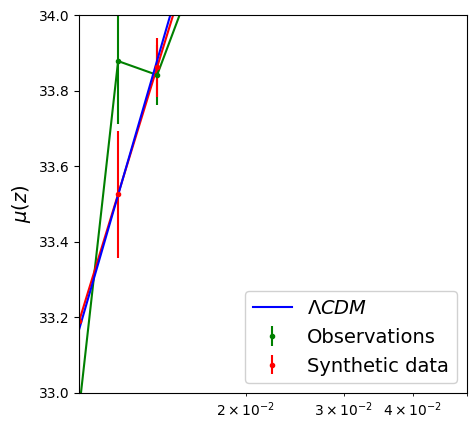

In [19]:
plt.figure(figsize=(5, 5), dpi=100)

plt.errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
plt.plot(z_redshift, dist, c='g')
plt.errorbar(zpoints, dlfake, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.', label='Synthetic data')
plt.plot(zpoints, dlfake, c='r')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].fill_between(zmodel, flcdm - 1*0.104, flcdm + 1*0.104, alpha=0.5)
# axs[0].plot(zmodel, fowacdm1, label='CPL $w_0 = -1.09, w_a=0.3', c='m')
plt.ylabel("$\mu(z)$", fontsize=14)
plt.xscale('log')
plt.xlim(1e-2, 0.05)
plt.ylim(33,34)
plt.xticks([])
# plt.text(0.1, 44.5, 'FFNN', fontsize=15)
plt.legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)


## Visualize results to FFNN+VAE

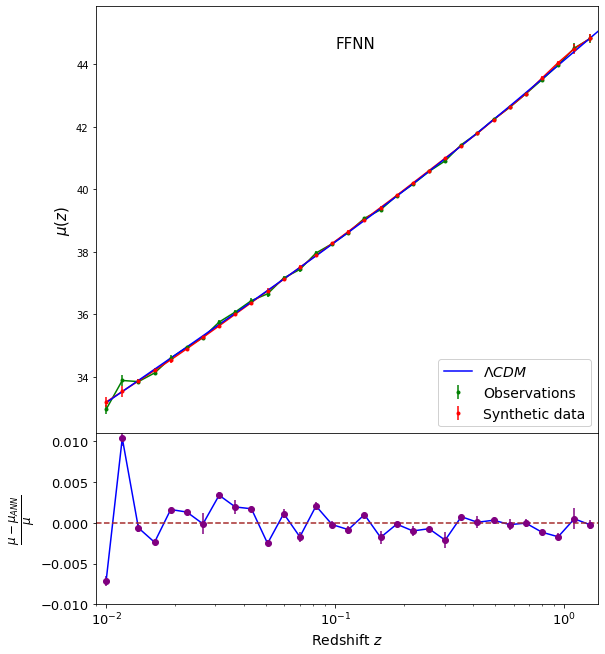

In [20]:
fig, axs = plt.subplots(2,1,figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
axs[0].plot(z_redshift, dist, c='g')
axs[0].errorbar(zpoints, dlfake, yerr=np.sqrt(np.diag(newmatrixr)), c='r',  fmt='.', label='Synthetic data')
axs[0].plot(zpoints, dlfake, c='r')
axs[0].plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].fill_between(zmodel, flcdm - 1*0.104, flcdm + 1*0.104, alpha=0.5)
# axs[0].plot(zmodel, fowacdm1, label='CPL $w_0 = -1.09, w_a=0.3', c='m')
axs[0].set_ylabel("$\mu(z)$", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_xlim(0.009, 1.4)
axs[0].set_xticks([])
axs[0].text(0.1, 44.5, 'FFNN', fontsize=15)
axs[0].legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            

axs[1].errorbar(z_redshift, (mudiff/dist), yerr=errdiff, c='purple',  fmt='o')
axs[1].plot(z_redshift, (mudiff/dist), c='b')
axs[1].set_xlim(0.009, 1.4)
axs[1].set_ylim(-1/100, 1.1/100)
# axs[1].set_ylabel(r"$ \frac{\mu - \mu_{ANN}}{\mu}$", fontsize=14)
axs[1].set_ylabel(r"$\frac{\mu - \mu_{ANN}}{\mu}$", fontsize=17)
axs[1].set_xscale('log')
axs[1].axhline(0, c='brown', linestyle='dashed')



# axs[2].scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
# axs[2].scatter(zpoints, np.sqrt(np.diag(newmatrixr)), c='r', marker='.', label='ANN errors')
# axs[2].scatter(z_redshift, errdiff, c='b', \
#                 marker='^', label="Difference between original and ANN errors" )

# axs[2].set_xlim(0.009, 1.4)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-5, 1)
# axs[2].set_ylabel("error", fontsize=14)
# axs[2].legend(fontsize=10, loc='center', framealpha=1, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0) 

plt.xlabel('Redshift $z$', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# for a in axs:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

plt.savefig('ffnn_jla.png')

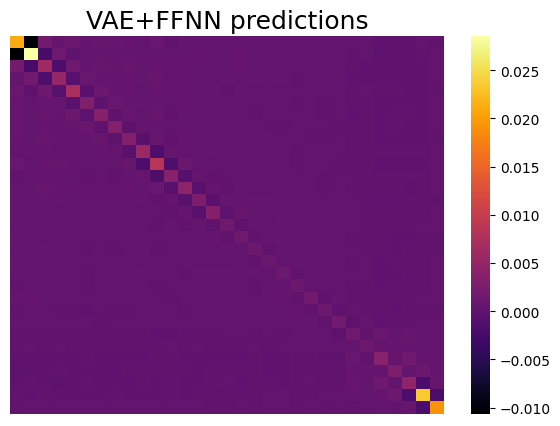

In [21]:
plt.figure(figsize=(7, 5), dpi=100)
plt.title('VAE+FFNN predictions', fontsize=18)

sns.heatmap(newmatrixr, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# sns.set(font_scale=1)
# np.savetxt("fake_binned_JLA_COVAE_DO.dat", newmatrixr_do, delimiter= " ", header="#fake COV")
plt.savefig('vae_cov_ffnn.png')

# Now with MC-DO

In [22]:
pred_random_do = ffnn_do.predict(np.log10(zpoints))
dlfake_do = scalerdist.inverse_transform(pred_random_do[:,0].reshape(-1,1))
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake_do.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLADO_inter.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [23]:
mean_pred_interpoint_DO = np.mean(dlfake_do)
std_pred_interpoint_DO = np.std(dlfake_do)

In [24]:
z_sample_do = np.array([mean_pred_interpoint_DO+delta_mean])

newmatrix_do = decoder.predict(z_sample_do)
newmatrixr_do = newmatrix_do.reshape(31,31)

mudiff_do = np.subtract(dist, dlfake_do.reshape(31,))
errdiff_do = np.subtract(np.sqrt(errors), np.sqrt(np.diag(newmatrixr_do)))

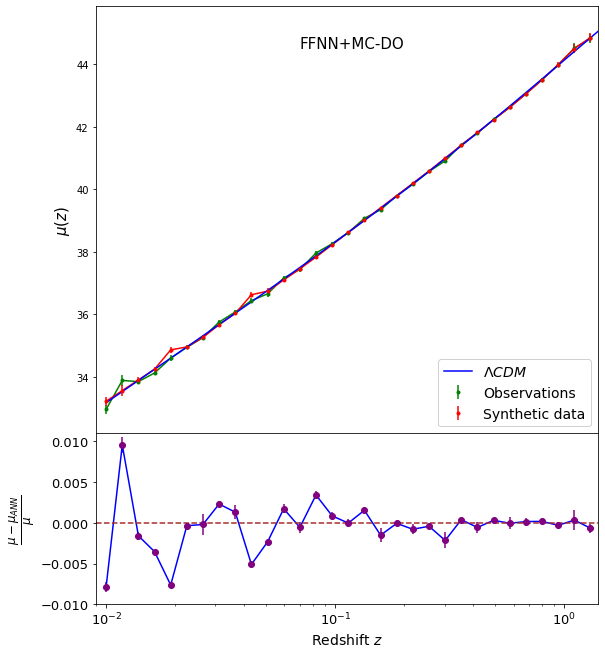

In [25]:
fig, axs = plt.subplots(2,1, figsize=(9, 11), gridspec_kw={'height_ratios': [5, 2]})

axs[0].errorbar(z_redshift, dist, yerr=np.sqrt(errors), c='g',  fmt='.', label='Observations')
axs[0].plot(z_redshift, dist, c='g')
axs[0].errorbar(zpoints, dlfake_do, yerr=np.sqrt(np.diag(newmatrixr_do)), c='r',  fmt='.', label='Synthetic data')
axs[0].plot(zpoints, dlfake_do, c='r')
axs[0].plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# axs[0].plot(zmodel, fowacdm2, label='CPL $w_0 = -1.04, w_a=-0.3', c='m')
axs[0].set_ylabel("$\mu(z)$", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_xlim(0.009, 1.4)
axs[0].set_xticks([])
axs[0].text(0.07, 44.5, 'FFNN+MC-DO', fontsize=15)
axs[0].legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            
axs[1].errorbar(z_redshift, (mudiff_do/dist), yerr=errdiff_do, c='purple',  fmt='o')
axs[1].plot(z_redshift, (mudiff_do/dist), c='b')
axs[1].set_xlim(0.009, 1.4)
axs[1].set_ylim(-1/100, 1.1/100)
axs[1].set_ylabel(r"$\frac{\mu - \mu_{ANN}}{\mu}$", fontsize=17)
axs[1].set_xscale('log')
axs[1].axhline(0, c='brown', linestyle='dashed')



# axs[2].scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')
# axs[2].scatter(zpoints, np.sqrt(np.diag(newmatrixr_do)), c='r', marker='.', label='ANN errors')
# axs[2].scatter(z_redshift, errdiff_do, c='b', \
#                 marker='^', label="Difference between original and ANN errors" )

# axs[2].set_xlim(0.009, 1.4)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_ylim(1e-5, 1)
# axs[2].set_ylabel("error", fontsize=14)
# axs[2].legend(fontsize=10, loc='center', framealpha=1, ncol=3)

plt.subplots_adjust(wspace=0, hspace=0) 


plt.xlabel('Redshift $z$', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# for a in axs:
#     a.set_xticklabels([])
#     a.set_yticklabels([])

plt.savefig('ffnn_jla_do.png')

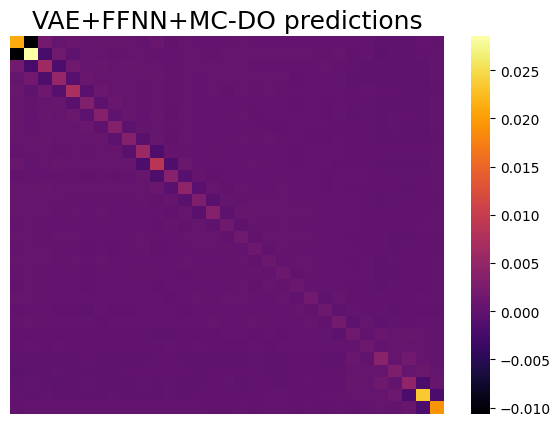

In [26]:
plt.figure(figsize=(7, 5), dpi=100)
plt.title('VAE+FFNN+MC-DO predictions', fontsize=18)

sns.heatmap(newmatrixr_do, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# sns.set(font_scale=1)
# np.savetxt("fake_binned_JLA_COVAE_DO.dat", newmatrixr_do, delimiter= " ", header="#fake COV")
plt.savefig('vae_cov_ffnn_do.png')

# Comparing ALL

Text(0.5, 0, 'Modulus distance $\\mu (z)$')

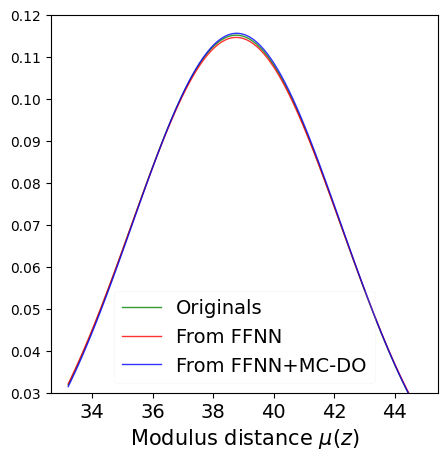

In [27]:
plt.figure(figsize=(5, 5), dpi=100, facecolor='white')
# plt.grid(b=None)

xmin = np.min(dlfake_do)
xmax= np.max(dlfake_do)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)
y3 = sp.stats.norm.pdf(x, mean_pred_interpoint_DO, std_pred_interpoint_DO)


plt.plot(x, y1, label='Originals', color='g', linewidth=1, alpha=0.8)
plt.plot(x, y2, label='From FFNN', color='r', linewidth=1, alpha=0.8)
plt.plot(x, y3, label='From FFNN+MC-DO', color='b', linewidth=1, alpha=0.8)
plt.ylim(0.03,0.12)

# plt.grid(True)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# plt.show()
# dist_sc
# plt.yscale('log')
plt.legend(fontsize=14, loc='lower center', framealpha=0.1)
# plt.yticks([])
plt.xticks(fontsize=14)
# plt.yscale('log')
# plt.xlim(36,42)
# plt.ylim(0.09,0.117)
plt.xlabel("Modulus distance $\mu (z)$", fontsize=15)
# plt.savefig('modulus_dist_gauss.png')

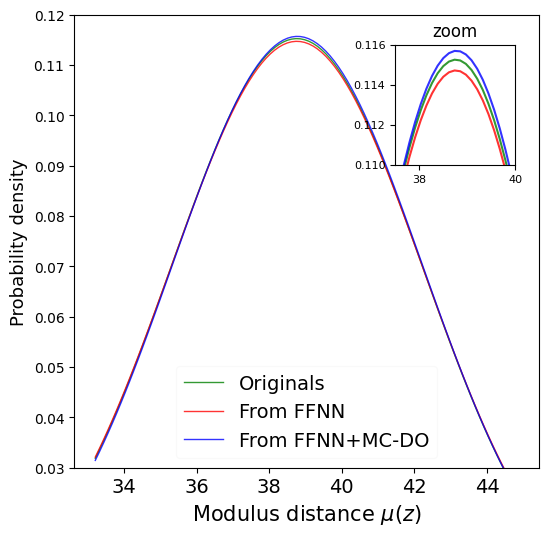

In [41]:
plt.figure(figsize=(6, 6), dpi=100, facecolor='white')
# plt.grid(b=None)

xmin = np.min(dlfake_do)
xmax= np.max(dlfake_do)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)
y3 = sp.stats.norm.pdf(x, mean_pred_interpoint_DO, std_pred_interpoint_DO)


plt.plot(x, y1, label='Originals', color='g', linewidth=1, alpha=0.8)
plt.plot(x, y2, label='From FFNN', color='r', linewidth=1, alpha=0.8)
plt.plot(x, y3, label='From FFNN+MC-DO', color='b', linewidth=1, alpha=0.8)
plt.ylim(0.03,0.12)

# plt.grid(True)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# plt.show()
# dist_sc
# plt.yscale('log')
plt.legend(fontsize=14, loc='lower center', framealpha=0.1)
# plt.yticks([])
plt.xticks(fontsize=14)
# plt.yscale('log')

plt.xlabel("Modulus distance $\mu (z)$", fontsize=15)
plt.ylabel("Probability density",  fontsize=13)
# plt.savefig('modulus_dist_gauss.png')
a = plt.axes([.66, .63, .2, .2], facecolor='w')
plt.plot(x, y1, label='Originals', color='g', linewidth=1.5, alpha=0.8)
plt.plot(x, y2, label='From FFNN', color='r', linewidth=1.5, alpha=0.8)
plt.plot(x, y3, label='From FFNN+MC-DO', color='b', linewidth=1.5, alpha=0.8)
plt.xlim(37.5,40)
plt.ylim(0.11,0.116)
plt.title('zoom')
# n, bins, patches = plt.hist(s, 400, normed=1)
# plt.title('Probability')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig('modulus_dist_gauss.png')

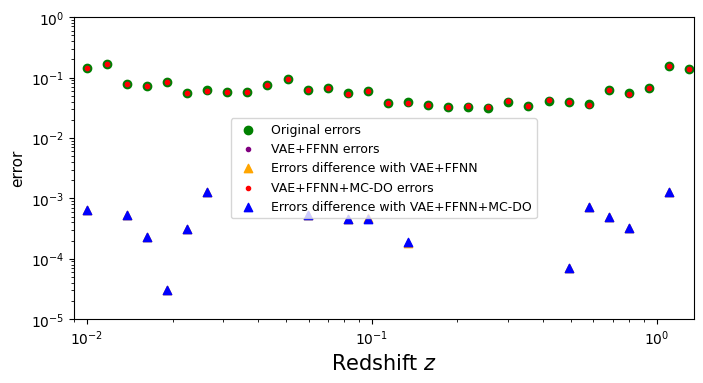

In [29]:
plt.figure(figsize=(8, 4), dpi=100)

                                    
plt.scatter(z_redshift, np.sqrt(errors), c='g', marker='o', label='Original errors')

plt.scatter(zpoints, np.sqrt(np.diag(newmatrixr)), c='purple', marker='.', label='VAE+FFNN errors')
plt.scatter(z_redshift, errdiff, c='orange', \
            marker='^', label="Errors difference with VAE+FFNN" )

plt.scatter(zpoints, np.sqrt(np.diag(newmatrixr_do)), c='r', marker='.', label='VAE+FFNN+MC-DO errors')
plt.scatter(z_redshift, errdiff_do, c='b', \
            marker='^', label="Errors difference with VAE+FFNN+MC-DO" )

plt.xlim(0.009, 1.35)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel("error", fontsize=11)
plt.legend(fontsize=9, loc='center')

<AxesSubplot:>

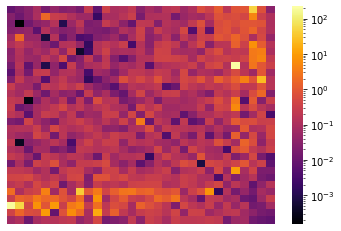

In [30]:
perc_matrix = np.abs((syscov - newmatrixr)/ syscov)
perc_matrix_do = np.abs((syscov - newmatrixr_do)/ syscov)
sns.heatmap(perc_matrix_do, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True, norm=LogNorm() )

In [31]:
syscov_pos = syscov.reshape(31*31,)[syscov.reshape(31*31,)>0]
syscov_neg = np.abs(syscov.reshape(31*31,)[syscov.reshape(31*31,)<0])
                    
covffnn_pos = newmatrixr.reshape(31*31,)[newmatrixr.reshape(31*31,)>0]
covffnn_neg = np.abs(newmatrixr.reshape(31*31,)[newmatrixr.reshape(31*31,)<0])
                     
covdo_pos = newmatrixr_do.reshape(31*31,)[newmatrixr_do.reshape(31*31,)>0]
covdo_neg = np.abs(newmatrixr_do.reshape(31*31,)[newmatrixr_do.reshape(31*31,)<0])


<Figure size 1200x1000 with 0 Axes>

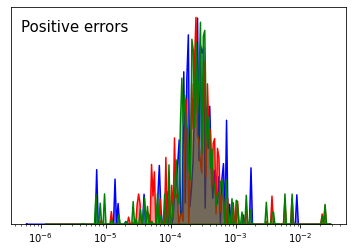

In [32]:
plt.figure(figsize=(12,10), dpi=100)
# ax1 = sns.displot(perc_matrix.reshape(31*31,), kind='kde', log_scale=True)
# ax2 = sns.displot(perc_matrix_do.reshape(31*31,), kind='kde', log_scale=True)
fig, ax = plt.subplots()
# sns.kdeplot(perc_matrix.reshape(31*31,), ax=ax, log_scale=True, \
#             linewidth=2, fill=True, alpha=0.4, color='red',bw_adjust=0.02, \
#             label='VAE with FFNN')

# sns.kdeplot(perc_matrix_do.reshape(31*31,), ax=ax, log_scale=True, \
#             linewidth=2, fill=True, alpha=0.4, color='green', bw_adjust=0.02, \
#             label='VAE with FFNN+MC-DO')

sns.kdeplot(syscov_pos, ax=ax, log_scale=True, \
            linewidth=1.5, fill=True, alpha=0.4, color='blue', bw_adjust=0.01, \
            label='Original', )

sns.kdeplot(covffnn_pos, ax=ax, log_scale=True, \
            linewidth=1.5, fill=True, alpha=0.4, color='red', bw_adjust=0.01, \
            label='VAE with FFNN')

sns.kdeplot(covdo_pos, ax=ax, log_scale=True, \
            linewidth=1.5, fill=True, alpha=0.4, color='green', bw_adjust=0.01, \
            label='VAE with FFNN+MC-DO')


plt.yticks([])
plt.ylabel('', fontsize=0)
plt.text(5*1e-7, 2.5, 'Positive errors', fontsize=15)

# plt.xlabel(r'$ \|real\; error - error \; prediction \| \div \|real\;error\|$', \
#            fontsize=11)
# plt.xlabel('Positive errors', fontsize=12)
# plt.xlim(np.min(syscov), np.max(syscov))
# plt.legend(loc='upper left', fontsize=11, framealpha=0)
plt.savefig('dist_errors_covs_pos.png')

<Figure size 1200x1000 with 0 Axes>

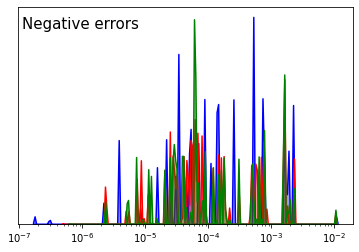

In [33]:
plt.figure(figsize=(12,10), dpi=100)
# ax1 = sns.displot(perc_matrix.reshape(31*31,), kind='kde', log_scale=True)
# ax2 = sns.displot(perc_matrix_do.reshape(31*31,), kind='kde', log_scale=True)
fig, ax = plt.subplots()
# sns.kdeplot(perc_matrix.reshape(31*31,), ax=ax, log_scale=True, \
#             linewidth=2, fill=True, alpha=0.4, color='red',bw_adjust=0.02, \
#             label='VAE with FFNN')

# sns.kdeplot(perc_matrix_do.reshape(31*31,), ax=ax, log_scale=True, \
#             linewidth=2, fill=True, alpha=0.4, color='green', bw_adjust=0.02, \
#             label='VAE with FFNN+MC-DO')

sns.kdeplot(syscov_neg, ax=ax, log_scale=True, \
            linewidth=1.5, fill=True, alpha=0.4, color='blue', bw_adjust=0.01, \
            label='Original', )

sns.kdeplot(covffnn_neg, ax=ax, log_scale=True, \
            linewidth=1.5, fill=True, alpha=0.4, color='red', bw_adjust=0.01, \
            label='VAE with FFNN')

sns.kdeplot(covdo_neg, ax=ax, log_scale=True, \
            linewidth=1.5, fill=True, alpha=0.4, color='green', bw_adjust=0.01, \
            label='VAE with FFNN+MC-DO')

plt.yticks([])
plt.ylabel('', fontsize=0)
plt.text(1.1*1e-7, 3.8, 'Negative errors', fontsize=15)

# plt.xlabel(r'$ \|real\; error - error \; prediction \| \div \|real\;error\|$', \
#            fontsize=11)
# plt.xlabel('Negative errors', fontsize=12)
# plt.xlim(np.min(syscov), np.max(syscov))
# plt.legend(loc='upper left', fontsize=11, framealpha=0)
plt.savefig('dist_errors_covs_neg.png')

In [34]:
np.max(perc_matrix)

222.84239919373175

In [35]:
( perc_matrix > 100).sum()

2

In [36]:
(perc_matrix > 5).sum()

17

In [37]:
( perc_matrix > 1).sum()

67

In [38]:
( perc_matrix < 1).sum()

894